## Load essential libraries

In [555]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import time
from collections import Counter
import warnings

%matplotlib inline
plt.style.use('ggplot')

import miner_py3 as miner

## Define functions for state inference

In [ ]:
def louvain(matrix,min_cluster_size=1,rbf=True,distance_matrix=False):
    
    import numpy as np
    import pandas as pd
    import community
    import networkx as nx
    from scipy.spatial.distance import cdist
    from sklearn.metrics.pairwise import rbf_kernel, laplacian_kernel
    
    if type(matrix) is pd.core.frame.DataFrame:
        df = True
        columns = matrix.columns
        matrix = np.array(matrix)
       
    n = matrix.shape[0]
    
    if distance_matrix is False:
        if rbf is True:
            distance_matrix = rbf_kernel(matrix.T,gamma=None)

        elif rbf is False:
            distance_matrix = laplacian_kernel(matrix.T,gamma=None)
    elif distance_matrix is True:
        distance_matrix = matrix
    
    # calculate maximum distance for normalization
    max_distance = float(np.amax(distance_matrix))

    # generate list of edges with node and weight information 
    elist = []
    for i in range(distance_matrix.shape[0]):
        for j in range(i,distance_matrix.shape[0]):
            elist.append((i,j,distance_matrix[i,j]/max_distance))

    # instantiate graph and add edge information
    G = nx.Graph()
    G.add_weighted_edges_from(elist)

    # apply the louvain algorithm to identify the best patitions
    partition = community.best_partition(G)

    # retrieve clusters in dictionary form
    louvain_clusters = {}
    for name in list(partition.keys()):
        value = partition[name]
        if value not in list(louvain_clusters.keys()):
            louvain_clusters[value] = []
        louvain_clusters[value].append(name)

    # Convert clusters to original ids in list form
    if df is True:
        louvain_list = [list(columns[louvain_clusters[key]]) for key in list(louvain_clusters.keys())]
        
    else:
        louvain_list = [list(louvain_clusters[key]) for key in list(louvain_clusters.keys())]
        
    return louvain_list

## Define paths to data and results

In [2]:
# Path to the miner directory
input_path = os.path.join(os.path.expanduser('~'),'Desktop','GitHub','miner','miner')

# create name for results folder where output files will be saved
resultsFolder = "state_clustering_results"

# name of the folder containing the miner network
#networkFolder = "miner_network_results"
networkFolder = "results_minCorrelation_0o2_50_allFiles"

# create results directory
resultsDirectory = os.path.join(os.path.split(os.getcwd())[0],resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

## Load network data

In [3]:
# Load expression Data
expressionFile = os.path.join(input_path,"data","expression","IA12Zscore.csv")
#expressionData = pd.read_csv(expressionFile,index_col=0,header=0)
expressionData, conversionTable = miner.preprocess(expressionFile)

# Load mutations
common_mutations = pd.read_csv(os.path.join(input_path,'data','mutations','commonMutations.csv'),index_col=0,header=0)
translocations = pd.read_csv(os.path.join(input_path,'data','mutations','translocationsIA12.csv'),index_col=0,header=0)
cytogenetics = pd.read_csv(os.path.join(input_path,'data','mutations','cytogenetics.csv'),index_col=0,header=0)
cytogenetics = cytogenetics.loc[:,list(set(cytogenetics.columns)&set(expressionData.columns))]
common_patients_mutations_translocations = list(set(translocations.columns)&set(common_mutations.columns))
mutation_matrix = pd.concat([common_mutations.loc[:,common_patients_mutations_translocations],translocations.loc[:,common_patients_mutations_translocations]],axis=0)

#If previous results exist, use miner.read_json to load them
revisedClusters = miner.read_json(os.path.join(input_path,networkFolder,"coexpressionDictionary.json"))
coexpressionModules = miner.read_json(os.path.join(input_path,networkFolder,"coexpressionModules.json"))
regulonModules = miner.read_json(os.path.join(input_path,networkFolder,"regulons.json"))
mechanisticOutput = miner.read_json(os.path.join(input_path,networkFolder,"mechanisticOutput.json"))
regulonDf = pd.read_csv(os.path.join(input_path,networkFolder,"regulonDf.csv"),index_col=0,header=0)
overExpressedMembersMatrix = pd.read_csv(os.path.join(input_path,networkFolder,"overExpressedMembers.csv"),index_col=0,header=0)
overExpressedMembersMatrix.index = np.array(overExpressedMembersMatrix.index).astype(str)
underExpressedMembersMatrix = pd.read_csv(os.path.join(input_path,networkFolder,"underExpressedMembers.csv"),index_col=0,header=0)
underExpressedMembersMatrix.index = np.array(underExpressedMembersMatrix.index).astype(str)
eigengenes = pd.read_csv(os.path.join(input_path,networkFolder,"eigengenes.csv"),index_col=0,header=0)
eigengenes.index = np.array(underExpressedMembersMatrix.index).astype(str)

#Load table for converting gene names
id_table_path = os.path.join(os.path.expanduser("~"),"Desktop","GitHub","miner","miner","data","identifier_mappings.txt")
id_table = pd.read_csv(id_table_path,sep="\t")
id_table = id_table[id_table["Source"] == "Gene Name"]
id_table.index = id_table.iloc[:,0]

completed identifier conversion.
16216 genes were converted.


In [11]:
t1 = time.time()
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = regulonModules
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
# for each clus|ter, give samples that show low coherent cluster activity
underExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)

# write membership matrices to .csv file
overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)
underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))

t2 = time.time()
print("Completed patient mapping in {:.2f} minutes".format((t2-t1)/60.))

done!
done!
Completed patient mapping in 1.10 minutes


In [4]:
# Load transcriptional programs
transcriptional_programs = miner.read_json(os.path.join(input_path,networkFolder,'transcriptional_programs.json'))
program_list = [transcriptional_programs[str(key)] for key in range(len(transcriptional_programs.keys()))]

# Load transcriptional states
transcriptional_states = miner.read_json(os.path.join(input_path,networkFolder,'transcriptional_states.json'))
states_list = [transcriptional_states[str(key)] for key in range(len(transcriptional_states.keys()))]
final_state = list(set(expressionData.columns)-set(np.hstack(states_list)))
if len(final_state)>0:
    states_list.append(final_state)
states = states_list.copy()
diff_matrix_MMRF = overExpressedMembersMatrix-underExpressedMembersMatrix

states_df = pd.DataFrame(np.zeros((len(states),expressionData.shape[1])))
states_df.index = list(range(1,len(states)+1))
states_df.columns = expressionData.columns

for i in range(len(states)):
    states_df.loc[i+1,states[i]] = 1


state_labels = pd.DataFrame(np.zeros((expressionData.shape[1],1)))
state_labels.index = expressionData.columns
state_labels.columns = ["state"]
for j in range(states_df.shape[0]):
    s = states_df.index[j]
    state_labels.loc[states[j],"state"] = int(s)

state_labels.head()

,state
MMRF_1270_1_BM,16.0
MMRF_1037_1_BM,4.0
MMRF_2644_1_BM,1.0
MMRF_1235_1_BM,9.0
MMRF_1621_1_BM,4.0


In [5]:
# Create dictionary of program genes
# make dictionary of genes by program
pr_genes = {}
for i in range(len(program_list)):
    rgns = program_list[i]
    genes = []
    for r in rgns:
        genes.append(regulonModules[r])
    genes = list(set(np.hstack(genes)))
    pr_genes[i] = genes

In [6]:
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = pr_genes
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers_pr = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
# for each clus|ter, give samples that show low coherent cluster activity
underExpressedMembers_pr = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)
# for each cluster, give samples that do not show coherent cluster activity
# dysregulatedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="excluded")
# # for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
# coherentMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="included")

# write membership matrices to .csv file
overExpressedProgramsMatrix_pr = miner.membershipToIncidence(overExpressedMembers_pr,expressionData)
#overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedProgramsMatrix_pr = miner.membershipToIncidence(underExpressedMembers_pr,expressionData)
#underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))

# Generate program activity difference matrix
dfr_pr = overExpressedProgramsMatrix_pr - underExpressedProgramsMatrix_pr

done!
done!


## UMAP

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
   metric_kwds=None, min_dist=0.25, n_components=2, n_epochs=None,
   n_neighbors=15, negative_sample_rate=5, random_state=None,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=True)
Construct fuzzy simplicial set
Fri Dec  4 11:02:18 2020 Finding Nearest Neighbors
Fri Dec  4 11:02:18 2020 Finished Nearest Neighbor Search
Fri Dec  4 11:02:18 2020 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri Dec  4 11:02:19 2020 

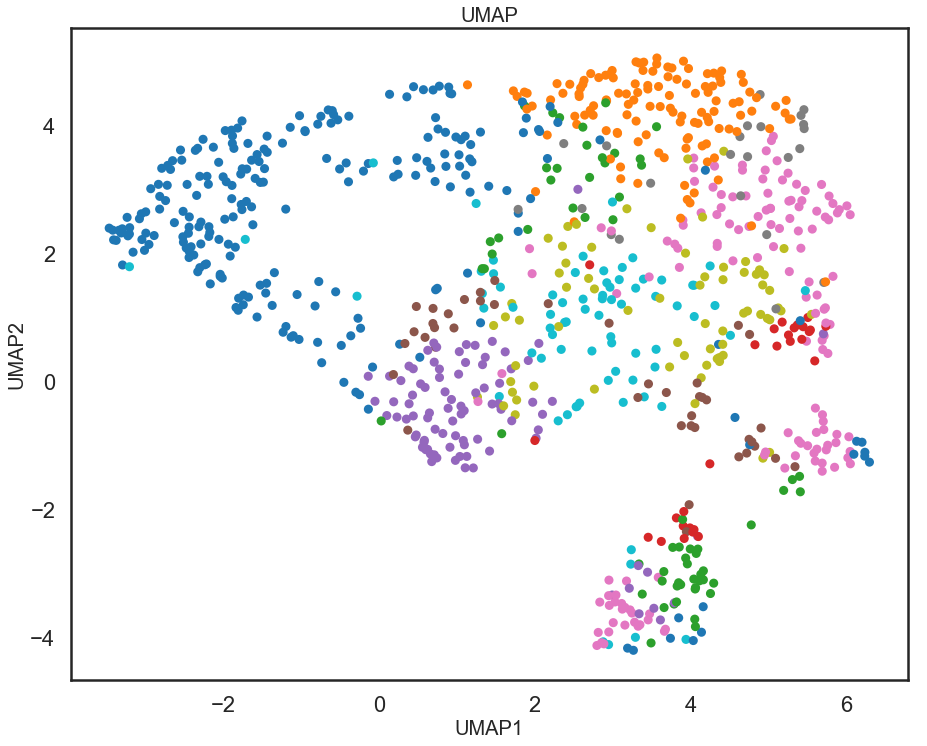

In [186]:
from umap import UMAP
plt.figure(figsize=(15,12))
model = UMAP(n_neighbors = 15, min_dist = 0.25, n_components = 2, verbose = True)

X_train = diff_matrix_MMRF.T

umap = model.fit_transform(X_train)
plt.scatter(umap[:, 0], umap[:, 1], c = np.array(state_labels.iloc[:,0]).astype(int),cmap = 'tab10', s = 50) #c = y_train.astype(int)
plt.title('UMAP', fontsize = 20)
plt.xlabel("UMAP1", fontsize = 20)
plt.ylabel("UMAP2", fontsize = 20)
plt.show()

## Method 1: HDBSCAN

In [187]:
import hdbscan

In [188]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as data
%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

In [189]:
#Cluster with HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=9, gen_min_span_tree=True)
clusterer.fit(umap)


HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_epsilon=0.0,
    cluster_selection_method='eom', core_dist_n_jobs=4,
    gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='euclidean', min_cluster_size=9, min_samples=None, p=None,
    prediction_data=False)

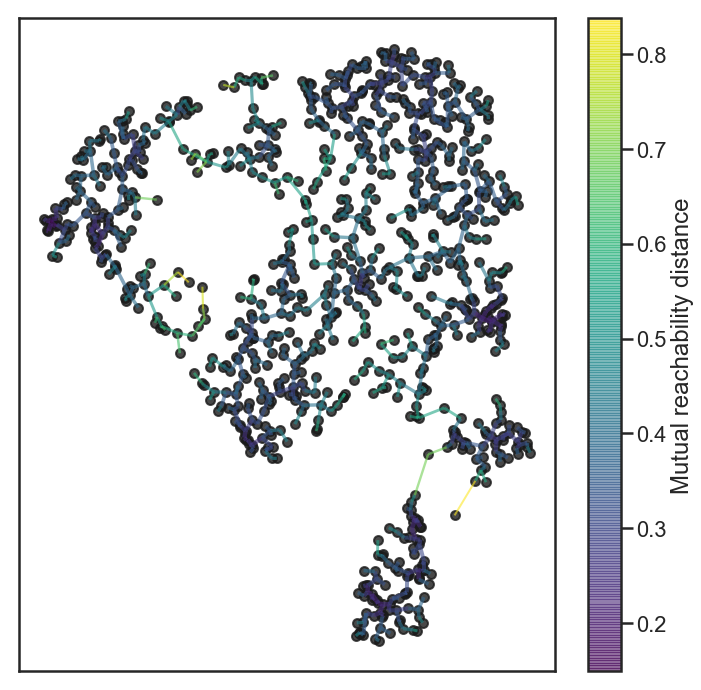

In [190]:
plt.figure(figsize=(12,12))
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)

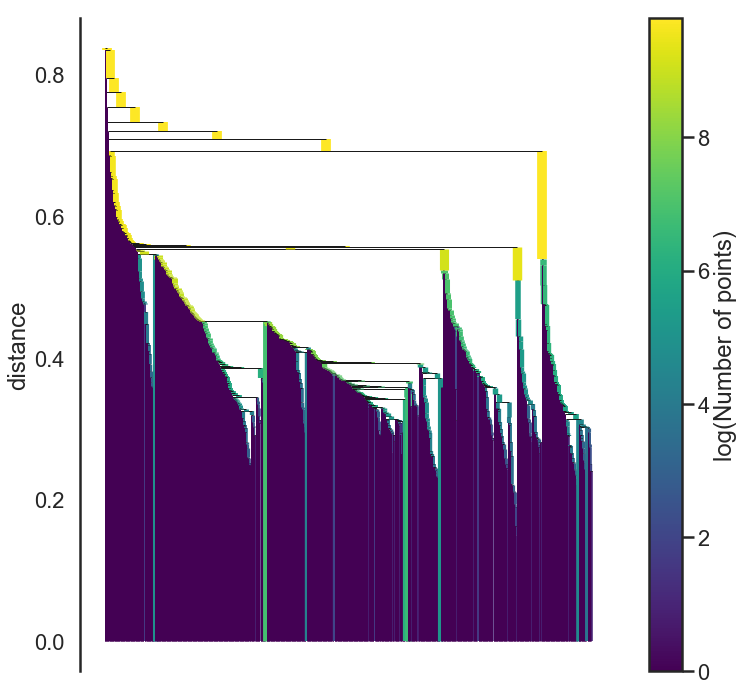

In [191]:
plt.figure(figsize=(12,12))
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

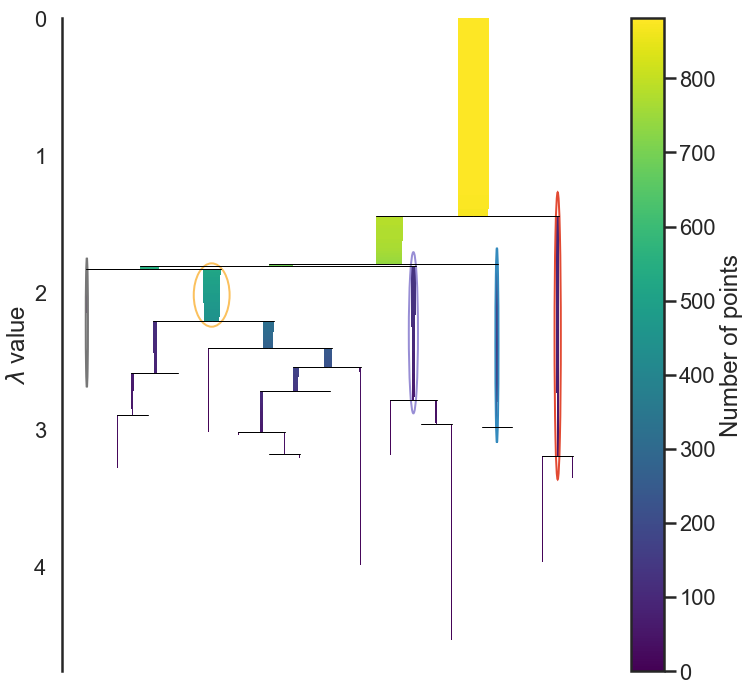

In [192]:
plt.figure(figsize=(12,12))
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

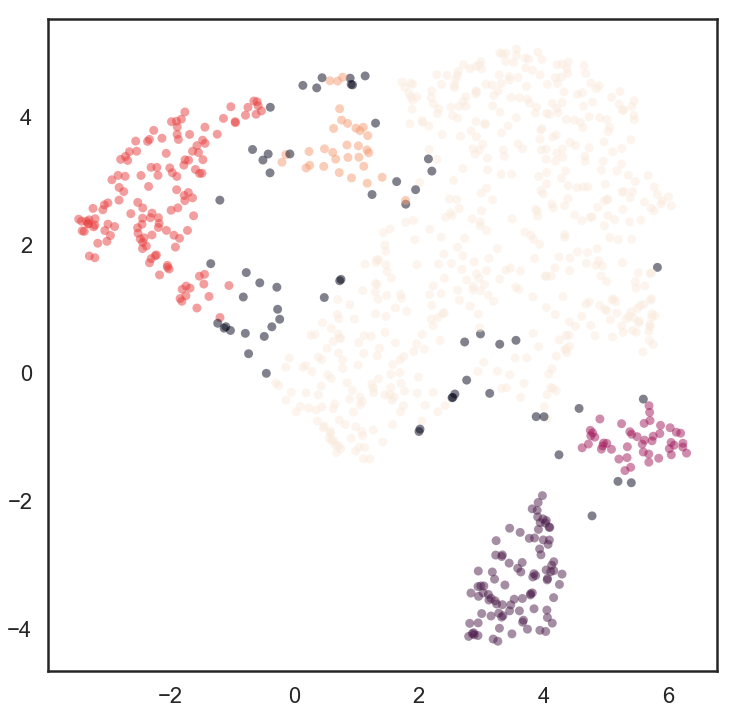

In [193]:
plt.figure(figsize=(12,12))
palette = sns.color_palette()
#cluster_colors = [sns.desaturate(palette[col], sat)
#                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
#                  list(zip(clusterer.labels_, clusterer.probabilities_))]

plt.scatter(umap.T[0], umap.T[1], c=clusterer.labels_, **plot_kwds)

In [194]:
hdbscan_results = pd.DataFrame(clusterer.labels_)
hdbscan_results.columns = ["cluster"]
hdbscan_results.index = eigengenes.columns

In [195]:
hdbscan_states = []
for c in hdbscan_results.cluster.unique():
    tmp_state = hdbscan_results.index[np.where(hdbscan_results.iloc[:,0]==c)[0]]
    hdbscan_states.append(tmp_state)

In [196]:
hdbscan_results.cluster.unique()

array([ 4,  2, -1,  1,  3,  0])

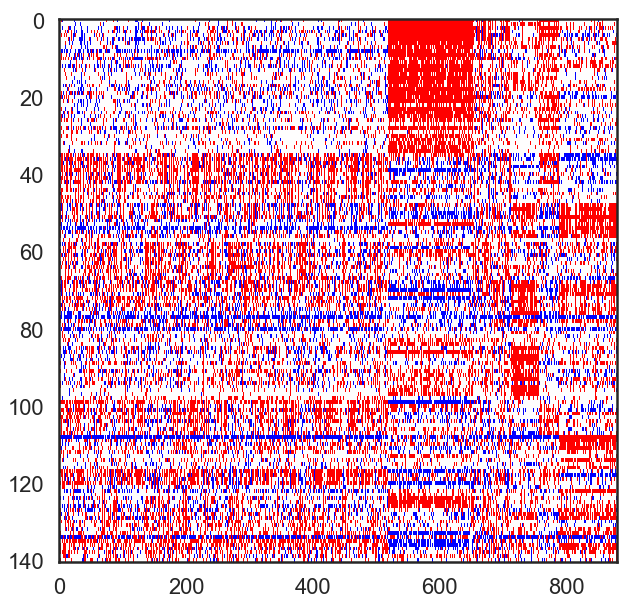

In [197]:
plt.figure(figsize=(10,10))
plt.imshow(dfr_pr.loc[:,np.hstack(hdbscan_states)],aspect="auto",cmap="bwr")

## Method 2: Louvain

In [65]:
#Generate similarity matrix for over-expressed members
scm_over = sampleCoincidenceMatrix(overExpressedMembers,frequencies=True)
over_sim_mat = scm_over*scm_over.T

#Generate similarity matrix for under-expressed members
scm_under = sampleCoincidenceMatrix(underExpressedMembers,frequencies=True)
under_sim_mat = scm_under*scm_under.T

In [66]:
#Define matrix for clustering
data_for_clustering = over_sim_mat
alternative_data = under_sim_mat
data_for_plotting = diff_matrix_MMRF
min_size = 9
use_rbf = False
dist_mat = True

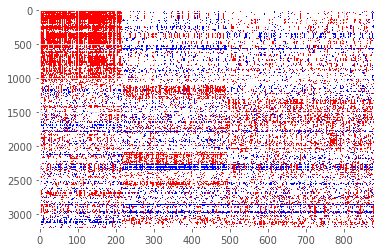

In [67]:
#Primary clustering
louvain_primary = louvain(data_for_clustering,min_cluster_size=min_size,rbf=use_rbf,distance_matrix = dist_mat)
plt.imshow(data_for_plotting.loc[np.hstack(program_list),np.hstack(louvain_primary)],aspect="auto",cmap="bwr")

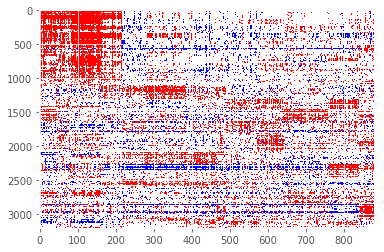

In [68]:
#Louvain sub-clustering on clusters of previous step
louvain_secondary = []
for c in louvain_primary:
    tmp_clusters = louvain(data_for_clustering.loc[c,c],min_cluster_size=min_size,
                           rbf=use_rbf,distance_matrix = dist_mat)
    louvain_secondary.extend(tmp_clusters)
    
plt.imshow(data_for_plotting.loc[np.hstack(program_list),np.hstack(louvain_secondary)],
           aspect="auto",cmap="bwr")

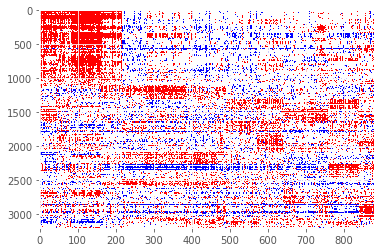

In [69]:
#Louvain sub-clustering on clusters of previous step
louvain_tertiary = []
for c in louvain_secondary:
    tmp_clusters = louvain(data_for_clustering.loc[c,c],min_cluster_size=min_size,
                           rbf=use_rbf,distance_matrix = dist_mat)
    lens = [len(k) for k in tmp_clusters]
    if min(lens)<min_size:
        louvain_tertiary.append(c)
    else:
        louvain_tertiary.extend(tmp_clusters)
        
plt.imshow(data_for_plotting.loc[np.hstack(program_list),np.hstack(louvain_tertiary)],
           aspect="auto",cmap="bwr")

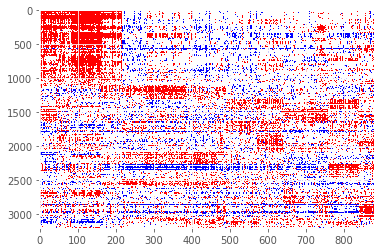

In [70]:
#Louvain sub-clustering on clusters of previous step
louvain_final = []
for c in louvain_tertiary:
    tmp_clusters = louvain(alternative_data.loc[c,c],min_cluster_size=min_size,
                           rbf=use_rbf,distance_matrix = dist_mat)
    lens = [len(k) for k in tmp_clusters]
    if min(lens)<min_size:
        louvain_final.append(c)
    else:
        louvain_final.extend(tmp_clusters)
        
plt.imshow(data_for_plotting.loc[np.hstack(program_list),np.hstack(louvain_final)],
           aspect="auto",cmap="bwr")

In [71]:
for i in range(len(states)):
    for j in range(len(louvain_final)):
        overlap = len(miner.intersect(louvain_final[j],states[i]))/float(min(len(louvain_final[j]),len(states[i])))
        if overlap >= 0.5:
            print("Louvain {:d} matches State {:d} with {:.2f}% overlap".format(i,j,100.0*overlap))

Louvain 0 matches State 0 with 64.58% overlap
Louvain 0 matches State 2 with 74.03% overlap
Louvain 1 matches State 1 with 56.76% overlap
Louvain 1 matches State 3 with 54.55% overlap
Louvain 2 matches State 3 with 70.00% overlap
Louvain 3 matches State 5 with 64.52% overlap
Louvain 3 matches State 8 with 100.00% overlap
Louvain 4 matches State 4 with 54.84% overlap
Louvain 5 matches State 5 with 60.00% overlap
Louvain 6 matches State 17 with 100.00% overlap
Louvain 7 matches State 16 with 78.38% overlap
Louvain 8 matches State 10 with 76.47% overlap
Louvain 9 matches State 16 with 72.73% overlap
Louvain 10 matches State 16 with 90.00% overlap
Louvain 11 matches State 12 with 89.47% overlap
Louvain 11 matches State 14 with 52.17% overlap
Louvain 12 matches State 13 with 73.91% overlap
Louvain 13 matches State 15 with 77.78% overlap
Louvain 14 matches State 9 with 91.67% overlap
Louvain 15 matches State 10 with 85.11% overlap
Louvain 16 matches State 6 with 95.16% overlap
Louvain 17 mat

## Method 3: Kmeans

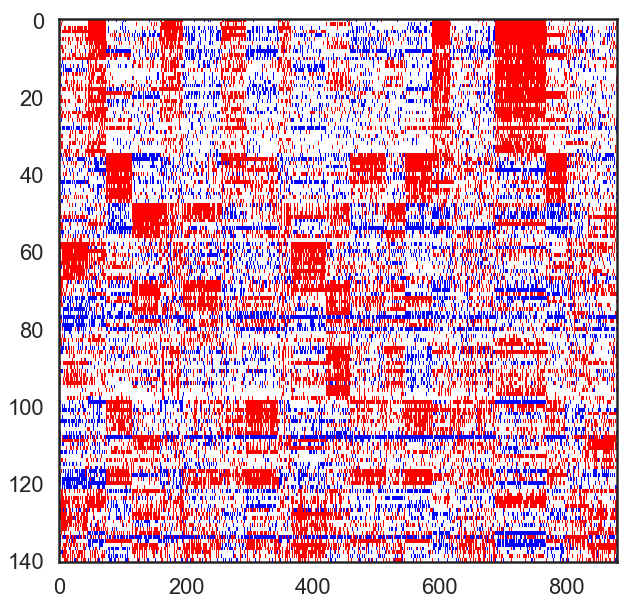

In [321]:
n_clusters = 20
kmeans_states, labels, centroids = miner.kmeans(sim_mat.T,n_clusters)
plt.figure(figsize=(10,10))
plt.imshow(dfr_pr.loc[:,np.hstack(kmeans_states)],aspect="auto",cmap="bwr")
plt.grid(False)

## Method 4: Hierarchical clustering

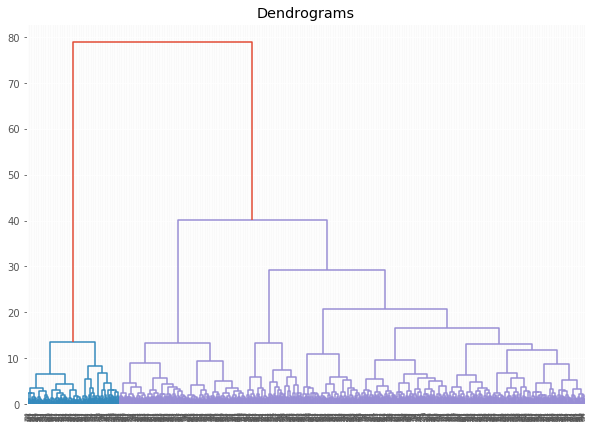

In [74]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(sim_mat.T, method='ward'))

In [107]:
from sklearn.cluster import AgglomerativeClustering
n_clusters = 20
cluster = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')  
hierarchical_labels = pd.DataFrame(cluster.fit_predict(dfr_pr.T))
hierarchical_labels.index = eigengenes.columns
hierarchical_labels.columns = ["cluster"]


In [108]:
hierarchical_states = []
for c in hierarchical_labels.cluster.unique():
    tmp_state = hierarchical_labels.index[np.where(hierarchical_labels.iloc[:,0]==c)[0]]
    hierarchical_states.append(tmp_state)

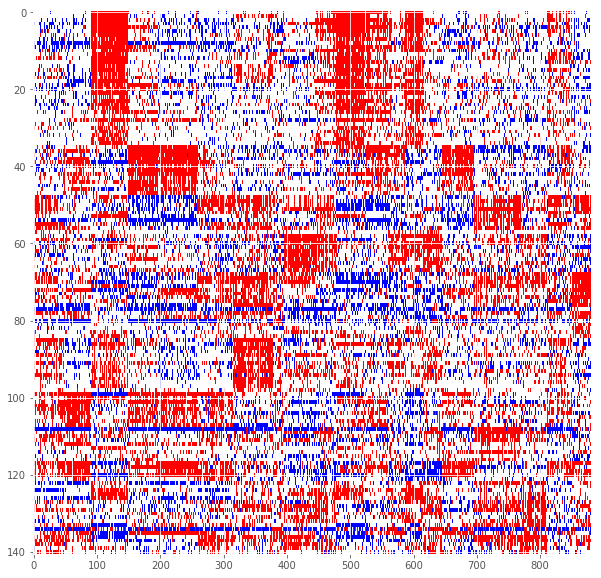

In [109]:
plt.figure(figsize=(10,10))
plt.imshow(dfr_pr.loc[:,np.hstack(hierarchical_states)],aspect="auto",cmap="bwr")

## Method 5: MINER F1 decomposition

In [91]:
t1 = time.time()
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = regulonModules
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
# for each clus|ter, give samples that show low coherent cluster activity
underExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)

# write membership matrices to .csv file
overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)
underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))

t2 = time.time()
print("Completed patient mapping in {:.2f} minutes".format((t2-t1)/60.))

done!
done!
Completed patient mapping in 1.12 minutes


In [559]:
#Suppress warnings
warnings.filterwarnings("ignore")

# Infer transcriptional states
minClusterSize = 8 #int(np.ceil(0.01*expressionData.shape[1]))
referenceMatrix = overExpressedMembersMatrix-underExpressedMembersMatrix
primaryMatrix = overExpressedMembersMatrix
primaryDictionary = overExpressedMembers
secondaryMatrix = underExpressedMembersMatrix
secondaryDictionary = underExpressedMembers

states_, centroidClusters = miner.inferSubtypes(referenceMatrix,primaryMatrix,secondaryMatrix,primaryDictionary,secondaryDictionary,minClusterSize = minClusterSize,restricted_index=None)
final_state = list(set(expressionData.columns)-set(np.hstack(states_)))
if len(final_state)>0:
    states_.append(final_state)
#miner.write_json(states_dictionary,os.path.join(resultsDirectory,"transcriptional_states.json"))

Beginning subtype inference
completed subtype inference in 0.92 minutes


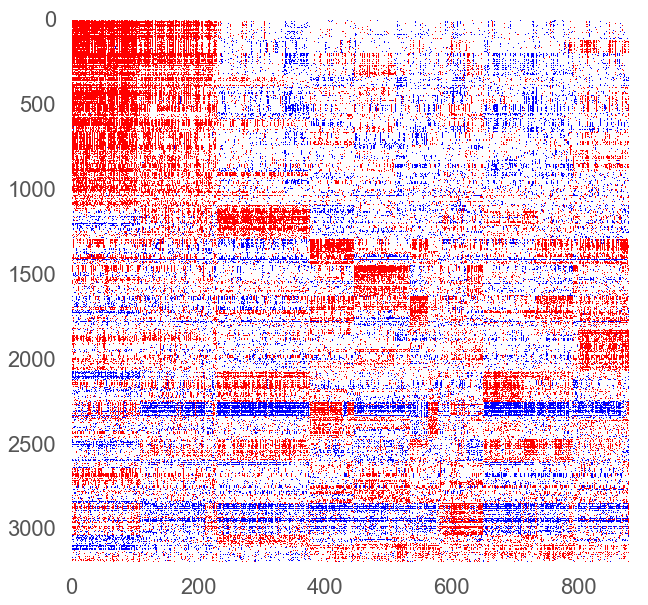

In [560]:
plt.figure(figsize=(10,10))
plt.imshow(diff_matrix_MMRF.loc[np.hstack(program_list),np.hstack(states_)],aspect="auto",cmap="bwr")
plt.grid(False)

In [561]:
for i in range(len(states_)):
    for j in range(len(states)):
        overlap = len(miner.intersect(states_[i],states[j]))/float(min(len(states_[i]),len(states[j])))
        if overlap >= 0.5:
            print("Alt. state {:d} matches State {:d} with {:.2f}% overlap".format(i,j,100.0*overlap))

Alt. state 0 matches State 0 with 97.12% overlap
Alt. state 1 matches State 1 with 93.81% overlap
Alt. state 2 matches State 2 with 90.91% overlap
Alt. state 3 matches State 25 with 88.89% overlap
Alt. state 4 matches State 3 with 94.62% overlap
Alt. state 4 matches State 5 with 70.00% overlap
Alt. state 4 matches State 19 with 50.00% overlap
Alt. state 5 matches State 4 with 96.77% overlap
Alt. state 6 matches State 7 with 81.08% overlap
Alt. state 6 matches State 10 with 80.00% overlap
Alt. state 7 matches State 9 with 54.55% overlap
Alt. state 8 matches State 11 with 76.79% overlap
Alt. state 8 matches State 12 with 52.17% overlap
Alt. state 11 matches State 14 with 83.33% overlap
Alt. state 12 matches State 17 with 77.78% overlap
Alt. state 13 matches State 6 with 66.67% overlap
Alt. state 13 matches State 19 with 50.00% overlap
Alt. state 13 matches State 22 with 76.92% overlap
Alt. state 13 matches State 24 with 50.00% overlap
Alt. state 14 matches State 13 with 55.56% overlap
Al

## Plot clusters side-by-side

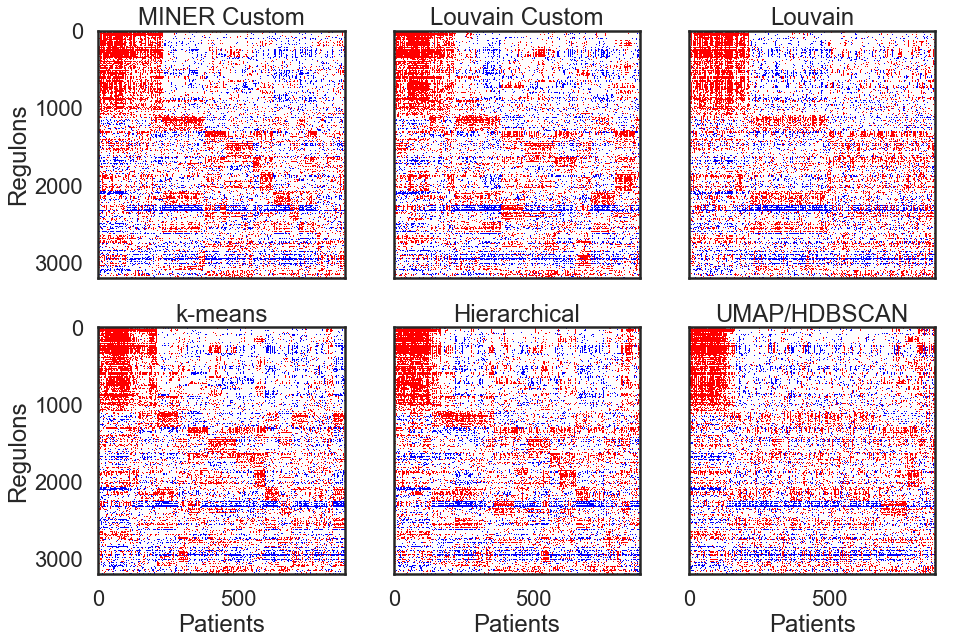

In [552]:
# Create figure with different clustering methods
fig, axs = plt.subplots(2, 3, sharey=True, sharex=True)
fig.set_figheight(10)
fig.set_figwidth(15)

#miner
axs[0, 0].imshow(diff_matrix_MMRF.loc[np.hstack(program_list),
                                       np.hstack(states)],aspect="auto",cmap="bwr")
axs[0, 0].set_title("MINER Custom")
axs[0, 0].set_ylabel("Regulons")

#louvain iterative
louvain_final_aligned = miner.align_to_reference(states_,louvain_final)
axs[0, 1].imshow(diff_matrix_MMRF.loc[np.hstack(program_list),
                                       np.hstack(louvain_final_aligned)],aspect="auto",cmap="bwr")
axs[0, 1].set_title("Louvain Custom")

#louvain
louvain_primary_aligned = miner.align_to_reference(states,louvain_primary)
axs[0, 2].imshow(diff_matrix_MMRF.loc[np.hstack(program_list),
                                       np.hstack(louvain_primary_aligned)],aspect="auto",cmap="bwr")
axs[0, 2].set_title("Louvain")

#kmeans
kmeans_aligned = miner.align_to_reference(states,kmeans_states)
axs[1, 0].imshow(diff_matrix_MMRF.loc[np.hstack(program_list),
                                       np.hstack(kmeans_aligned)],aspect="auto",cmap="bwr")
axs[1, 0].set_title("k-means")
axs[1, 0].set_ylabel("Regulons")
axs[1, 0].set_xlabel("Patients")

#hierarchical
hierarchical_aligned = miner.align_to_reference(states,hierarchical_states)
axs[1, 1].imshow(diff_matrix_MMRF.loc[np.hstack(program_list),
                                       np.hstack(hierarchical_aligned)],aspect="auto",cmap="bwr")
axs[1, 1].set_title("Hierarchical")
axs[1, 1].set_xlabel("Patients")

#hierarchical
hdbscan_aligned = miner.align_to_reference(states,hdbscan_states)
axs[1, 2].imshow(diff_matrix_MMRF.loc[np.hstack(program_list),
                                       np.hstack(hdbscan_aligned)],aspect="auto",cmap="bwr")
axs[1, 2].set_title("UMAP/HDBSCAN")
axs[1, 2].set_xlabel("Patients")

#Save figure
plt.savefig(os.path.join(os.path.expanduser("~"),"Desktop","cluster_comparison.pdf"),bbox_inches="tight")